In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

#from portfolio import Portfolio

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_35813/4192852674.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-20 10:54:17.293997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
class Asset:
    asset_dict = {}

    def __init__(self, ticker):
        self.ticker = ticker
        Asset.asset_dict[ticker] = self
        self.history = pd.DataFrame(columns = ['high', 'low', 'open', 'close', 'volume'],
                                    index = pd.DatetimeIndex([], name = 'date_time'))
    def latest_price(self):
        return self.price_on_date()
    
    def price_on_date(self, on_date = tmpstemp.today):
        matches = self.history.index.get_indexer([on_date], method='nearest')
        return self.history['close'].iloc[matches[0]]
    
    def update_history(self, incoming_df:pd.DataFrame):
        '''
        incoming_df: the dataframe with the new historical records
        '''
        self.history = pd.concat([self.history, incoming_df]).groupby(level=0).last()


In [3]:
class Portfolio:
    def __init__(self, origination_date = tmpstemp.fromisoformat('2000-01-01'), initial_deposit = 0):
        idx  = pd.MultiIndex(levels=[[],[]],
                          codes=[[],[]],
                          names=[u'date_time', u'ticker'])
        my_columns = [u'change', u'note']
        self.transactions  = pd.DataFrame(index=idx, columns=my_columns)
        self.value = pd.DataFrame(columns = ['value'], index = pd.DatetimeIndex([], name = 'date_time'))
        self.orig_date = origination_date
        self.update_transactions(transaction_date = origination_date,
                                ticker = 'USD',
                                qty = initial_deposit,
                                note = 'Initial deposit')


    def update_transactions(self, ticker:str, qty:float, transaction_date = tmpstemp.today(), note = ''):
        self.transactions.loc[(transaction_date,ticker),:] = [qty, note]

    def get_positions(self, on_date = tmpstemp.today()):
        '''
        Returns portfolio composition on the specified date
        '''
        # First, get the mask for all records before the date
        time_mask= self.transactions.index.get_level_values('date_time')<=on_date
        # Filter the df with this mask, group by ticker
        positions = self.transactions[time_mask]['change'].groupby(level = 'ticker').sum()
        # Convert resulting Series to DataFrame
        positions = pd.DataFrame(positions, index=pd.Index(positions.index, name = 'ticker'))
        positions.columns = ['position_size']
        
        # Add the value in USD by multiplying on the asset price at this date
        positions['position_value'] = positions.index.to_series().apply(
                                                lambda x: Asset.asset_dict[str(x)].price_on_date(on_date)
                                                )
        positions['position_value'] = positions['position_value']*positions['position_size']
        return positions

    def get_value(self, on_date = tmpstemp.today()):
        self.update_value()
        return self.value.loc[on_date]
    
    def update_value(self):
        #self.value.drop(self.value.index, inplace=True)
        date_to_add = tmpstemp.fromisoformat('2023-11-30')
        while date_to_add >= self.orig_date:
            composition_at_date = self.get_positions(date_to_add).dropna()
            value_to_add = composition_at_date.position_value.sum()
            self.value.loc[date_to_add] = value_to_add
            date_to_add = date_to_add - tmpdelta(days=1)


In [58]:
USD = Asset('USD')
date_range = pd.date_range(start=tmpstemp.fromisoformat('2000-01-01'), end=tmpstemp.today())
idx =pd.DatetimeIndex(date_range, name = 'date_time')
USD_2000 = pd.DataFrame({'low':[1] * len(idx), 'high':[1] * len(idx),
                    'open':[1] * len(idx), 'close':[1] * len(idx),
                    'volume':[1000]* len(idx)},
                     index=idx)
USD.update_history(USD_2000)

In [59]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [60]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    btc_data.set_index('date_time', inplace=True)
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    ETH_data.set_index('date_time', inplace=True)
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    USDT_data.set_index('date_time', inplace=True)
    USDT.update_history(USDT_data)

In [53]:
my_portfolio = Portfolio(origination_date=tmpstemp.fromisoformat('2021-12-01'), initial_deposit=100)
my_portfolio.update_transactions(ticker='BTC', qty=1, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='USDT', qty=40000, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.5, transaction_date=tmpstemp.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='USDT', qty=-10000, transaction_date=tmpstemp.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.25, transaction_date=tmpstemp.fromisoformat('2022-01-10'))
my_portfolio.update_transactions(ticker='USDT', qty=-20000, transaction_date=tmpstemp.fromisoformat('2022-01-10'))
my_portfolio.transactions

change             note
date_time  ticker                         
2021-12-01 USD        100  Initial deposit
2022-01-01 BTC          1                 
           USDT     40000                 
2022-01-02 BTC       -0.5                 
           USDT    -10000                 
2022-01-10 BTC      -0.25                 
           USDT    -20000

In [8]:
'''
# Plot data we got
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(BTC.history.index, BTC.history['close'], color = 'black', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        '''

"\n# Plot data we got\nfig, ax = plt.subplots(1, 1, sharex = True)\nfig.set_figheight(11)\nfig.set_figwidth(8.5)\nax.plot(BTC.history.index, BTC.history['close'], color = 'black', label = 'Historic price')\nfor tick in ax.get_xticklabels():\n        tick.set_rotation(45)\n        "

In [16]:
# Set up configuration objects and params
prediction_days = 15
scaler  = MinMaxScaler(feature_range=(0,1))
len_train = int(0.7*len(BTC.history))
len_test = len(BTC.history) - len_train
last_date_train = BTC.history.index[len_train]
first_date_val = BTC.history.index[len_train+1]

In [10]:
#Generate training data
x_train = []
y_train = []
scaled_data = scaler.fit_transform(np.array(BTC.history['close'].values).reshape(-1,1) )
for x in range(prediction_days, len_train):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
x_train, y_train = (np.array(x_train), np.array(y_train))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(474, 15, 1)

In [ ]:
# Create, compile, train the model
model = Sequential()
model.add(LSTM(units = 50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
optimizer = Adam(learning_rate=0.001, name='Adam')

model.compile(optimizer = optimizer, loss = 'mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=8)

In [97]:
input_data = BTC.history['close'].loc[first_date_val-tmpdelta(days=15):]
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for curr_date in input_data.index[(prediction_days-1):]:
    current_day_input = input_data[curr_date - tmpdelta(days=prediction_days-1):curr_date] # Data slice to be used in prediction
    model_input = scaler.fit_transform(np.array(current_day_input.values).reshape(-1,1) )  # Data scaled as input for the model
    model_input = np.array(model_input).reshape(1,prediction_days,1)                       # Data shaped as input for the model
    pred_BTC_price = model.predict(model_input,verbose = 0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price
    prediction_prices.append(pred_BTC_price)                                               # Save the result in the output array

    # Format string for output
    predicted_for_date = current_day_input.index[-1]+tmpdelta(days=1)                      # Get date we are predictig for 
    curr_BTC_price = input_data.loc[curr_date]                                             # Get current asset price 
    print(f'Today ({curr_date}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')

    current_positions = my_portfolio.get_positions(curr_date)
    if pred_BTC_price > curr_BTC_price:
        my_portfolio.update_transactions(ticker='BTC',
                                    qty = 0.01 * current_positions.loc['BTC', 'position_size'],
                                    transaction_date=curr_date)
    

Today (2023-05-04 20:00:00):29536.76, predicted for 2023-05-05 20:00:00: 28829.6796875
Today (2023-05-05 20:00:00):28902.66, predicted for 2023-05-06 20:00:00: 28901.62109375
Today (2023-05-06 20:00:00):28474.53, predicted for 2023-05-07 20:00:00: 28872.0546875
Today (2023-05-07 20:00:00):27695.06, predicted for 2023-05-08 20:00:00: 28705.46484375
Today (2023-05-08 20:00:00):27647.29, predicted for 2023-05-09 20:00:00: 28486.724609375
Today (2023-05-09 20:00:00):27624.01, predicted for 2023-05-10 20:00:00: 28243.888671875
Today (2023-05-10 20:00:00):26986.56, predicted for 2023-05-11 20:00:00: 27902.28515625
Today (2023-05-11 20:00:00):26808.84, predicted for 2023-05-12 20:00:00: 27602.5859375
Today (2023-05-12 20:00:00):26789.48, predicted for 2023-05-13 20:00:00: 27346.537109375
Today (2023-05-13 20:00:00):26929.98, predicted for 2023-05-14 20:00:00: 27149.990234375
Today (2023-05-14 20:00:00):27171.13, predicted for 2023-05-15 20:00:00: 27035.357421875
Today (2023-05-15 20:00:00):27

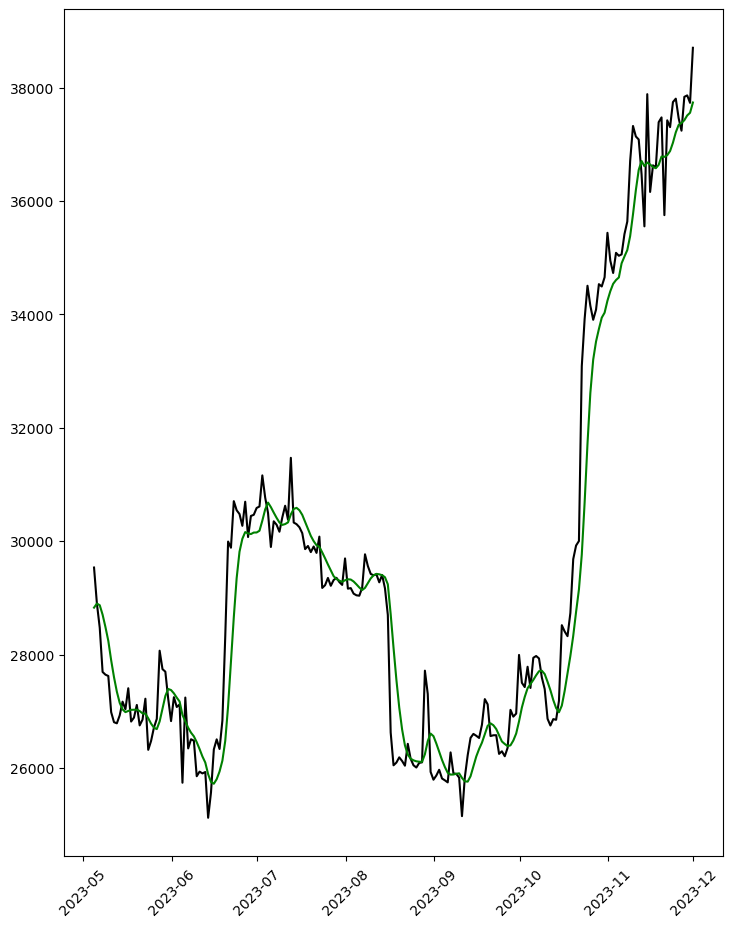

In [95]:
# Make data frame for final plotting
pred_df = pd.DataFrame(prediction_prices)
pred_df.columns = ['BTC_predicted']
plot_test = pd.concat([BTC.history.iloc[len_train:].reset_index(), pred_df[['BTC_predicted']].reset_index()], axis=1)

# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(plot_test['date_time'], plot_test['close'], color = 'black', label = 'Historic price')
ax.plot(plot_test['date_time'], plot_test['BTC_predicted'], color = 'green', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)

In [ ]:
my_portfolio.transactions.head(10)

change             note
date_time  ticker                           
2021-12-01 USD          100  Initial deposit
2022-01-01 BTC            1                 
           USDT       40000                 
2022-01-02 BTC         -0.5                 
           USDT      -10000                 
2022-01-10 BTC        -0.25                 
           USDT      -20000                 
2023-05-06 BTC       0.0025                 
2023-05-07 BTC     0.002525                 
2023-05-08 BTC      0.00255